In [1]:
import PatternStructure as ps
import AssociativeNetwork as nt
import functions as fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm
sns.set(style='white',font_scale=1.5)

In [2]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 5 # P
CELLS_PER_PATTERN = 100 
N_CHAINS = 1 # M
PATTERNS_PER_CHAIN = 5 # Q

DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

In [6]:
#Memory structure
kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
memories = ps.PatternStructure(n_cells=N_CELLS,
                            n_patterns=N_PATTERNS,
                            cells_per_pattern=CELLS_PER_PATTERN,
                            n_chains=N_CHAINS,
                            patterns_per_chain=PATTERNS_PER_CHAIN,
                            kernel=kernel)


memories.generate_patterns()
memories.generate_chains(chains=[[0,1,2,3,4,0]])
memories.build_interactions()

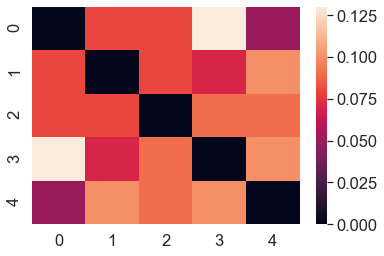

In [7]:
pattern_overlap = ps.pattern_overlap_matrix(memories)
sns.heatmap(pattern_overlap);

<AxesSubplot:>

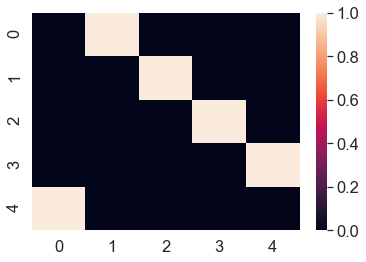

In [8]:
G = nx.from_numpy_matrix(memories.chain_transitions)
sns.heatmap(memories.chain_transitions)

In [9]:
starting_map = 0
net = nt.Network(J=memories.interaction_matrix, 
                 transfer_func=nt.ReLu,
                 dynamic_func=nt.net_dynamics)

initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
initial_config = initial_config/np.mean(initial_config)
net.run_dynamics(initial_config,n_steps=100,sparsity=DYNAMIC_SPARISTY)

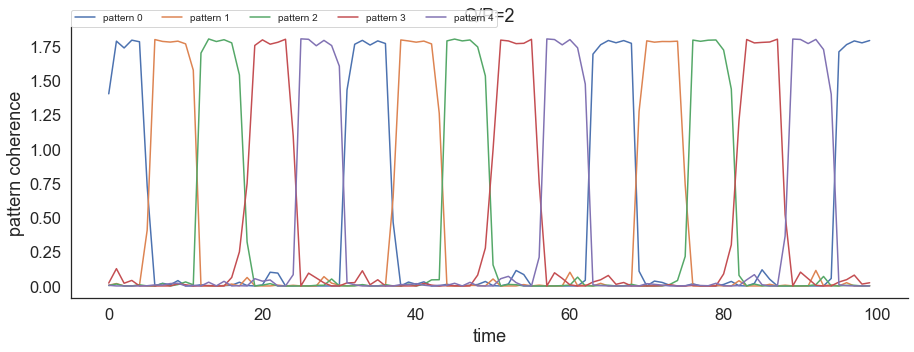

In [10]:
coherence = fs.coherence_timecourse(memories,net.history)
attractors = fs.attractors_timecourse(memories,net.history)
retrieved_sequence = fs.retrieved_sequence(memories,net.history)

plt.figure(figsize=(15,5))
for i,timecourse in enumerate(coherence):
    plt.plot(timecourse,label=f'pattern {i}')
plt.legend()

sns.despine()
plt.title('Q/P=2')
plt.xlabel('time')
plt.ylabel('pattern coherence')
plt.legend(fontsize = 10,loc=(0,1),ncol=5)

In [11]:
up_factor = 5

coherence = fs.coherence_timecourse(memories,net.history)
attractors = fs.attractors_timecourse(memories,net.history)
retrieved_sequence = fs.retrieved_sequence(memories,net.history)


resampled_coherence = []

x = np.arange(0,coherence.shape[1])
x_new = np.linspace(0,coherence.shape[1],coherence.shape[1]*up_factor)
for c in coherence:
    resampled_coherence.append(np.interp(x_new,x,c))

resampled_coherence = np.asarray(resampled_coherence)




x = np.arange(0,net.history.shape[0])
x_new = np.linspace(0,net.history.shape[0],net.history.shape[0]*up_factor)

resampled_history = []

for h in net.history.T:
    resampled_history.append(np.interp(x_new,x,h))

resampled_history = np.asarray(resampled_history)

print(resampled_history.shape)




(1000, 500)


In [25]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

X = resampled_coherence.T
embedding = PCA(n_components=2)
X_transformed = embedding.fit_transform(X)
attractors = embedding.fit_transform(1.75*np.identity(N_PATTERNS))
X_transformed.shape

(500, 2)

In [28]:
from pathlib import Path
import imageio
import shutil

pca_tail = 50

temp_folder = 'temp'

Path(temp_folder).mkdir(parents=True, exist_ok=True)

filenames = []

print('Creating frames ...')

for t in tqdm(range(len(resampled_coherence.T))):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5), gridspec_kw={'width_ratios': [1, 3]})

    ax1.set_title("2D embedding")
    # for a in attractors:
    #     ax1.scatter(a[0],a[1],marker='x',c='r',s=60)

    if t<=pca_tail:
        ax1.plot(X_transformed[:t,0],X_transformed[:t,1],linewidth=2)
    else:
        ax1.plot(X_transformed[t-pca_tail:t,0],X_transformed[t-pca_tail:t,1],linewidth=2)

    ax1.set_xlim([min(X_transformed[:,0]),max(X_transformed[:,0])])
    ax1.set_ylim([min(X_transformed[:,1]),max(X_transformed[:,1])])
    ax1.set_axis_off()


    for i,timecourse in enumerate(resampled_coherence):
        ax2.plot(timecourse[:t],label=f'pattern {i}')

    sns.despine()
    plt.title('Order parameter evolution')
    plt.xlabel('time')
    plt.ylabel('pattern coherence')
    plt.xlim([0,len(resampled_coherence.T)])
    plt.ylim([0,1.8])

    plt.tight_layout()
    plt.savefig(temp_folder+f'/img{t}.png')
    plt.close(fig)

    filenames.append(temp_folder+f'/img{t}.png')

print('Producing gif ... ')

with imageio.get_writer('prova.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

shutil.rmtree(temp_folder)

print('Done')





    

  0%|          | 0/500 [00:00<?, ?it/s]

Creating frames ...


100%|██████████| 500/500 [01:04<00:00,  7.71it/s]


Producing gif ... 
Done
